This work shows the possibility to study and predict the HIV-1 cleavage sites given the combination of sequence information, including amino acid binary profiles, bond composition, and physicochemical properties. The best performances are obtained via the Multi-Layer Perceptron classifier and similar results can be obtained with the Logistic Regression classifier. The k-NN classifier is the worst among the methods analyzed in this work.
The results could be improved by using a larger data set, that can be implemented via data augmentation techniques.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow import keras
from keras.optimizers import Optimizer, Adam
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout
from keras.callbacks import Callback, ModelCheckpoint
from keras.regularizers import l2
from keras.utils import plot_model
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
from itertools import product

In [8]:
#uploading the data into a dataframe

file_dir = '/content/gdrive/My Drive'

df_original = pd.read_excel(f"{file_dir}/12859_2022_5017_MOESM2_ESM.xlsx")

In [9]:
df=df_original

display(df)

df = df.iloc[:,1:]

,octamer,A1,C1,D1,E1,F1,G1,H1,I1,K1,...,PCP_AL,PCP_CY,PCP_AR,PCP_AC,PCP_BS,PCP_NE_pH,PCP_HB,PCP_HL,PCP_SC,cleavage Status
0,AECFRIFD,1,0,0,0,0,0,0,0,0,...,0.250,0.000,0.250,0.250,0.125,0.625,0.625,0.125,0.125,1
1,HLVEALYL,0,0,0,0,0,0,1,0,0,...,0.625,0.000,0.125,0.125,0.125,0.750,0.625,0.125,0.000,1
2,TQIMFETF,0,0,0,0,0,0,0,0,0,...,0.125,0.000,0.250,0.125,0.000,0.875,0.750,0.000,0.125,1
3,AEELAEIF,1,0,0,0,0,0,0,0,0,...,0.500,0.000,0.125,0.375,0.000,0.625,0.625,0.000,0.000,1
4,PFIFEEEP,0,0,0,0,0,0,0,0,0,...,0.375,0.250,0.250,0.375,0.000,0.625,0.625,0.250,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5843,YVPVTTFK,0,0,0,0,0,0,0,0,0,...,0.375,0.125,0.250,0.000,0.125,0.875,0.750,0.250,0.000,0
5844,YVQQHGGV,0,0,0,0,0,0,0,0,0,...,0.500,0.000,0.125,0.000,0.125,0.875,0.250,0.125,0.000,0
5845,YVSNIDGT,0,0,0,0,0,0,0,0,0,...,0.375,0.000,0.125,0.125,0.000,0.875,0.375,0.125,0.000,0
5846,YWPQEAGE,0,0,0,0,0,0,0,0,0,...,0.375,0.125,0.250,0.250,0.000,0.750,0.375,0.125,0.000,0


#Data Pre-processing

Number of non-cleaved sequences: 4847
Number of cleaved sequences: 1001
The data set is imbalanced


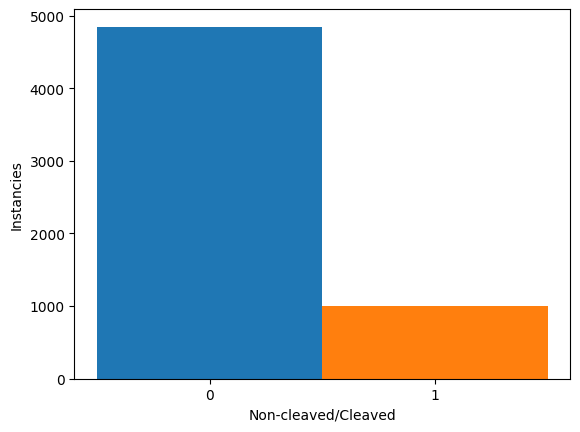

In [10]:
#showing the data distribution (occurences of 1,-1) in a plot
num_cleaved = df['cleavage Status'][df['cleavage Status'] == 1].count()
num_noncleaved = df['cleavage Status'][df['cleavage Status'] == 0].count()

df.groupby('cleavage Status')['cleavage Status'].hist(bins = 1)
plt.xlabel("Non-cleaved/Cleaved")
plt.xticks([0, 1])
plt.grid(False)
plt.ylabel("Instancies")

print('Number of non-cleaved sequences:', num_noncleaved)
print('Number of cleaved sequences:', num_cleaved)
print('The data set is imbalanced')

In [11]:
df_X = df[df.columns[:178]]
df_y = df[df.columns[-1]]

X = df_X.to_numpy()
y = df_y.to_numpy()

X = MinMaxScaler().fit_transform(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=42, stratify=y)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.33, shuffle=True, random_state=42,
    stratify=y_test)

In [13]:
train_df = pd.DataFrame(X_train, columns = df_X.columns)
train_df['cleavage Status'] = y_train

cleaved_train_df = train_df.loc[train_df['cleavage Status'] == 1]

# Cleaved entries (minority class) are 851 in the train set
# taking 851 entries from the non-cleaved sequence to balance the dataset
# using a random undersampling method
non_cleaved_train_df = train_df.loc[train_df['cleavage Status'] == 0].sample(
    n=851, random_state=42)

# Concatenate both dataframes again
equalized_train_df = pd.concat([non_cleaved_train_df, cleaved_train_df])

display(equalized_train_df)

,A1,C1,D1,E1,F1,G1,H1,I1,K1,L1,...,PCP_AL,PCP_CY,PCP_AR,PCP_AC,PCP_BS,PCP_NE_pH,PCP_HB,PCP_HL,PCP_SC,cleavage Status
1071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.375,0.00,0.00,0.125,0.500000,0.500,0.375,0.428571,0.000000,0
3219,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500,0.00,0.25,0.000,0.000000,1.000,0.375,0.000000,0.000000,0
3272,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.750,0.00,0.00,0.125,0.000000,0.875,0.500,0.000000,0.000000,0
2716,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.625,0.00,0.25,0.125,0.000000,0.875,0.375,0.000000,0.000000,0
3033,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.375,0.00,0.00,0.125,0.500000,0.500,0.125,0.428571,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.625,0.25,0.00,0.000,0.000000,1.000,0.875,0.142857,0.333333,1
4953,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.125,0.00,0.25,0.125,0.166667,0.750,0.375,0.285714,0.000000,1
4959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.250,0.25,0.00,0.250,0.000000,0.750,0.375,0.142857,0.333333,1
4961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.500,0.25,0.00,0.250,0.166667,0.625,0.625,0.285714,0.000000,1


Number of non-cleaved sequences in the training set: 851
Number of cleaved sequences in the training set: 851
Now the training set is balanced
Number of non-cleaved sequences in the validation set: 240
Number of cleaved sequences in the validation set: 50
Number of non-cleaved sequences in the test set: 488
Number of cleaved sequences in the test set: 100


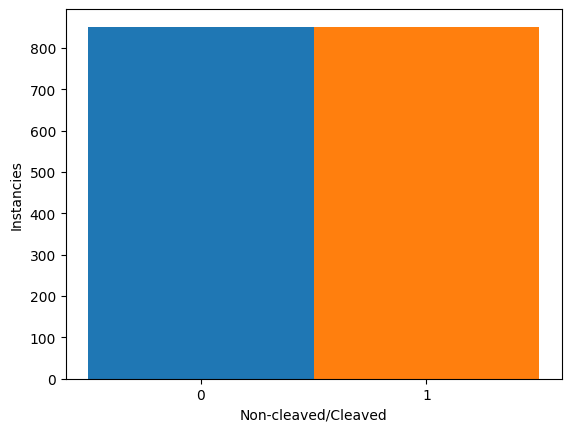

In [14]:
# Showing the instances for each class (test, training, validation)

num_cleaved_eq = equalized_train_df['cleavage Status'][equalized_train_df['cleavage Status'] == 1].count()
num_noncleaved_eq = equalized_train_df['cleavage Status'][equalized_train_df['cleavage Status'] == 0].count()

equalized_train_df.groupby('cleavage Status')['cleavage Status'].hist(bins = 1)
plt.xlabel("Non-cleaved/Cleaved")
plt.xticks([0, 1])
plt.grid(False)
plt.ylabel("Instancies")

print('Number of non-cleaved sequences in the training set:', num_noncleaved_eq)
print('Number of cleaved sequences in the training set:', num_cleaved_eq)
print('Now the training set is balanced')

print('Number of non-cleaved sequences in the validation set:',
      np.count_nonzero(y_val==0))
print('Number of cleaved sequences in the validation set:',
      np.count_nonzero(y_val==1))

print('Number of non-cleaved sequences in the test set:',
      np.count_nonzero(y_test==0))
print('Number of cleaved sequences in the test set:',
      np.count_nonzero(y_test==1))

In [15]:
X_train = equalized_train_df[equalized_train_df.columns[:178]].to_numpy()
y_train = equalized_train_df[equalized_train_df.columns[-1]].to_numpy()

# Method 1: DNN

##Hyperparameter optimization

In [17]:
# The GridSearchCV method, from the Scikit-learn’s model selection package,
# was used for the hyperparameter tuning.

param_space = {
    'dropout': [0, 0.2, 0.4],
    'l2_lambda': [0, 0.001, 0.01],
    'learning_rate': [0.001, 0.0001],
    'dense_nodes': [[8],[16],[32],[64],[128],
                    [8,4],[16,8],[32,16],[64,32]]
}

# Creating all the possible combination of hyperparameters
value_combis = product(*[v for v in param_space.values()])

param_combis = [{key:value for key, value in zip(param_space.keys(), combi)} for combi in value_combis]

print(f"We have a total of {len(param_combis)} combinations:")
print(param_combis)


class HistoryEpoch(Callback):
  """For saving the accuracy and loss values obtained at the end of each epoch
     during the training.
  """

  def __init__(self, data):
        self.data = data

  def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        logs['train_loss'] = l
        logs['train_accuracy'] = a

search_results = []

# Creating and compiling a model for each combination
for idx, params in enumerate(param_combis):

    optimizer = Adam(learning_rate=params['learning_rate'])

    print(f"Start run {idx+1}/{len(param_combis)}: Parameters: {params}")

    model = Sequential()
    model.add(InputLayer(X_train[0].shape))

    for nodes in params['dense_nodes']:
      model.add(Dense(nodes, activation='relu',
                      kernel_regularizer=l2(params['l2_lambda'])))
      model.add(Dropout(params['dropout']))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])
    #______________________________________________________________________________

    # choosing the best model as the one having the highest validation accuracy
    string_config = ""
    for key, value in params.items():
      string_config += key + "=" + str(value)
    filepath = f"paramsearch_filters_{string_config}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, monitor='val_accuracy', verbose=0,
        save_best_only=True, mode='max'
    )

    fit_results = model.fit(
      x=X_train,
      y=y_train,
      batch_size=64,
      epochs=30,
      validation_data=(X_val, y_val),
      callbacks=[checkpoint, HistoryEpoch((X_train, y_train))],
      verbose=0
    )

    # extract the best validation scores
    best_val_epoch    = np.argmax(fit_results.history['val_accuracy'])
    best_val_acc      = np.max(fit_results.history['val_accuracy'])
    best_val_acc_loss = fit_results.history['val_loss'][best_val_epoch]

    # get correct training accuracy
    train_loss_at_best_val_acc = fit_results.history['train_loss'][best_val_epoch]
    train_acc_at_best_val_acc = fit_results.history['train_accuracy'][best_val_epoch]

    # store results
    search_results.append({
        **params,
        'train_acc_at_best_val_acc': train_acc_at_best_val_acc,
        'best_val_acc': best_val_acc,
        'train_loss_at_best_val_acc': train_loss_at_best_val_acc,
        'best_val_acc_loss': best_val_acc_loss,
        'best_val_epoch': best_val_epoch,
        'history': fit_results.history
    })

We have a total of 162 combinations:
[{'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [8]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [16]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [32]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [64]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [128]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [8, 4]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [16, 8]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [32, 16]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [64, 32]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.0001, 'dense_nodes': [8]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.0001, 'dense_nodes': [16]}, {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.0001, 'dense_nodes': [32]}, {'dropout': 0, 'l2_lamb

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Start run 2/162: Parameters: {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [16]}
Start run 3/162: Parameters: {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [32]}
Start run 4/162: Parameters: {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [64]}
Start run 5/162: Parameters: {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [128]}
Start run 6/162: Parameters: {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [8, 4]}
Start run 7/162: Parameters: {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [16, 8]}
Start run 8/162: Parameters: {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [32, 16]}
Start run 9/162: Parameters: {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.001, 'dense_nodes': [64, 32]}
Start run 10/162: Parameters: {'dropout': 0, 'l2_lambda': 0, 'learning_rate': 0.0001, 'dense_nodes': [8]}
Start run 11/162: Parameters: {'dropout'

In [18]:
# which of the considered combinations perform best?

df_results = pd.DataFrame(search_results).sort_values(
    'best_val_acc', ascending=False)

# removing the only one critical hyperparameter set
df_results = df_results[df_results['train_acc_at_best_val_acc']>0.7]
df_results = df_results[df_results['best_val_acc']>0.7]

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(df_results)

,dropout,l2_lambda,learning_rate,dense_nodes,train_acc_at_best_val_acc,best_val_acc,train_loss_at_best_val_acc,best_val_acc_loss,best_val_epoch,history
5,0.0,0.000,1.000e-03,"[8, 4]",0.944,0.914,0.158,0.240,27,"{'loss': [0.6853909492492676, 0.65115767717361..."
94,0.2,0.010,1.000e-03,[128],0.932,0.914,0.256,0.283,26,"{'loss': [1.8355263471603394, 1.26258373260498..."
130,0.4,0.001,1.000e-03,[128],0.948,0.910,0.215,0.289,18,"{'loss': [0.769823431968689, 0.607751011848449..."
24,0.0,0.001,1.000e-03,"[16, 8]",0.887,0.910,0.478,0.368,4,"{'loss': [0.7351236939430237, 0.69581109285354..."
62,0.2,0.000,1.000e-03,"[64, 32]",0.968,0.910,0.116,0.235,10,"{'loss': [0.6743506193161011, 0.58239930868148..."
37,0.0,0.010,1.000e-03,[16],0.931,0.907,0.290,0.320,25,"{'loss': [0.9320341348648071, 0.80594563484191..."
112,0.4,0.000,1.000e-03,[128],0.951,0.907,0.145,0.230,12,"{'loss': [0.6359695196151733, 0.49760627746582..."
44,0.0,0.010,1.000e-03,"[64, 32]",0.938,0.907,0.274,0.316,27,"{'loss': [1.8156778812408447, 1.36178600788116..."
38,0.0,0.010,1.000e-03,[32],0.933,0.907,0.279,0.306,22,"{'loss': [1.123671293258667, 0.913131594657898..."
92,0.2,0.010,1.000e-03,[32],0.928,0.907,0.328,0.338,12,"{'loss': [1.1344609260559082, 0.93289637565612..."


In [19]:
df_results['delta_acc'] = (df_results['train_acc_at_best_val_acc']-df_results['best_val_acc'])/df_results['best_val_acc']

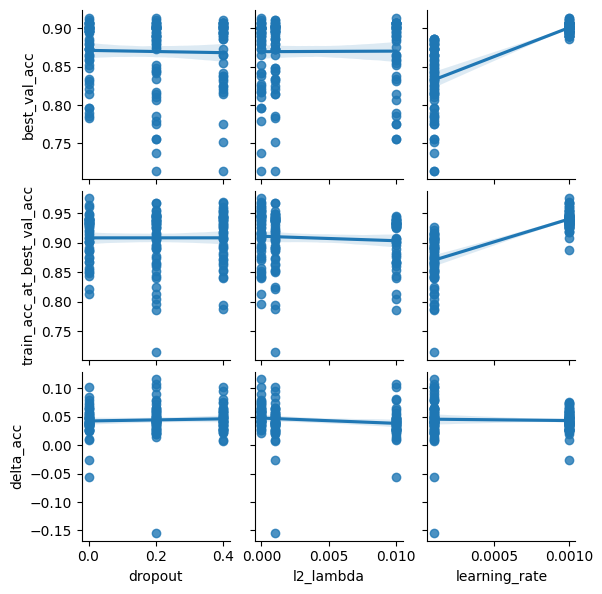

In [20]:
# comparison of the accuracy results with the different hyperparameters values
sns.pairplot(df_results,
             x_vars=['dropout', 'l2_lambda', 'learning_rate'],
             y_vars=['best_val_acc', 'train_acc_at_best_val_acc', 'delta_acc'],
             kind='reg', height=2)

plt.savefig(f"{file_dir}/HIV-CP Plots/Gridsearch Pairplot.png")
plt.show()

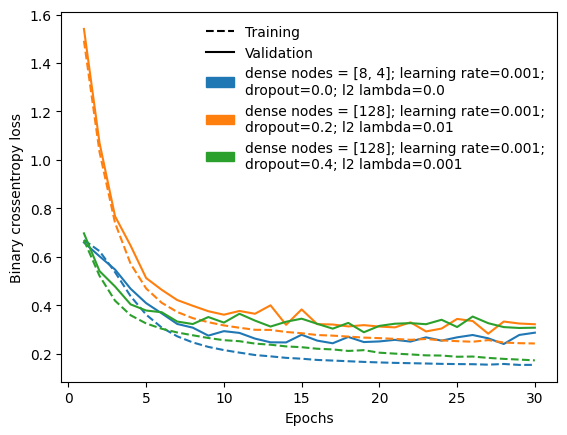

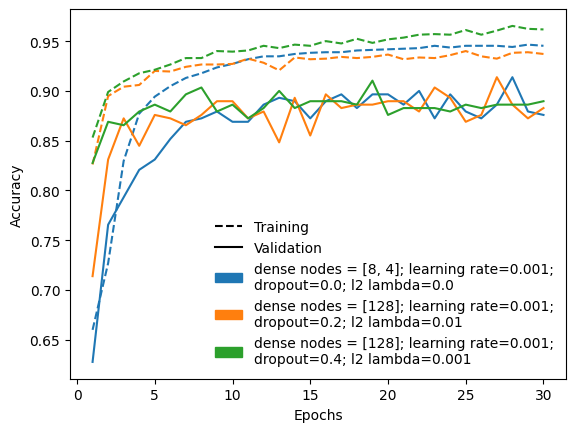

In [21]:
# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# plotting the loss curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df_results.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_loss'])+1)
  parameter_combination_string = f"dense nodes = {row_series['dense_nodes']}; learning rate={row_series['learning_rate']};\ndropout={row_series['dropout']}; l2 lambda={row_series['l2_lambda']}"
  plt.plot(x, row_series['history']['train_loss'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_loss'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)

plt.xlabel('Epochs')
plt.xticks(np.arange(0,32,step=5))
plt.ylabel('Binary crossentropy loss')

plt.legend(frameon=False)
plt.savefig(f"{file_dir}/HIV-CP Plots/Loss Gridsearch.png")
plt.show()


# empty plots, just to get the legend entries
plt.plot([],[],'k--', label='Training')
plt.plot([],[],'k-', label='Validation')

# plotting the accuracy curves of the three best performing models
for idx, (row_index, row_series) in enumerate(df_results.head(3).iterrows()):
  x = np.arange(1, len(row_series['history']['train_accuracy'])+1)
  parameter_combination_string = f"dense nodes = {row_series['dense_nodes']}; learning rate={row_series['learning_rate']};\ndropout={row_series['dropout']}; l2 lambda={row_series['l2_lambda']}"
  plt.plot(x, row_series['history']['train_accuracy'], '--', color=f'C{idx}')
  plt.plot(x, row_series['history']['val_accuracy'], '-', color=f'C{idx}')

  # and again empty, just for the legend entry
  plt.fill_between([],[],[],color=f'C{idx}', label=parameter_combination_string)


plt.xlabel('Epochs')
plt.xticks(np.arange(0,32,step=5))
plt.ylabel('Accuracy')

plt.legend(frameon=False)
plt.savefig(f"{file_dir}/HIV-CP Plots/Accuracy Gridsearch.png")
plt.show()

##Models

In [25]:
def plot_history(network_history, mod_num):
 """
    Plotting loss and accuracy values obtained for each epoch.
 """
 plt.figure()
 plt.xlabel('Epochs')
 plt.ylabel('Loss')
 plt.plot(network_history.history['loss'], '--')
 plt.plot(network_history.history['val_loss'], '-')
 plt.legend(['Training', 'Validation'],
              frameon=False)
 plt.savefig(f"{file_dir}//HIV-CP Plots/Loss MLP "+mod_num+".png")

 plt.figure()
 plt.xlabel('Epochs')
 plt.ylabel('Accuracy')
 plt.plot(network_history.history['accuracy'], '--')
 plt.plot(network_history.history['val_accuracy'], '-')
 plt.legend(['Training', 'Validation'],
             loc='lower right', frameon=False)
 plt.savefig(f"{file_dir}//HIV-CP Plots/Accuracy MLP "+mod_num+".png")

 plt.show()

In [28]:
# The training and validation loss of the fit history are not comparable when
# using dropout, so I have to define a callback function.

class HistoryEpoch(Callback):
  """
    Callback function which calculates the loss and the metric after each epoch
  """
  def __init__(self, data):
        self.data = data

  def on_train_begin(self, logs={}):
        self.loss = []
        self.acc = []

  def on_epoch_end(self, epoch, logs={}):
        x, y = self.data
        l, a = self.model.evaluate(x, y, verbose=0)
        self.loss.append(l)
        self.acc.append(a)

train_hist=HistoryEpoch((X_train, y_train))
val_hist=HistoryEpoch((X_val, y_val))
test_hist=HistoryEpoch((X_test, y_test))

From the best results on the hyperparameters obtained with the GridSearchCV, I have manually built 5 models. Each one of them has its accuracy vs epochs and loss vs epochs plotted.

In [29]:
learning_rate = 0.001
l2_lambda = 0.01
dropout = 0.4
optimizer = Adam(learning_rate=learning_rate)

model1 = Sequential([
      Dense(16, activation='relu', kernel_regularizer=l2(l2_lambda),
            input_dim=178),
      Dropout(dropout),
      Dense(8, activation='relu', kernel_regularizer=l2(l2_lambda)),
      Dropout(dropout),
      Dense(1, activation='sigmoid')
      ])

model1.compile(loss='binary_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
model1.summary()

history1 = model1.fit(x=X_train, y=y_train, batch_size=32, epochs=50,
                      validation_data=(X_val, y_val),
                      callbacks=[val_hist, train_hist, test_hist])

Model: "sequential_163"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_399 (Dense)           (None, 16)                2864      
                                                                 
 dropout_236 (Dropout)       (None, 16)                0         
                                                                 
 dense_400 (Dense)           (None, 8)                 136       
                                                                 
 dropout_237 (Dropout)       (None, 8)                 0         
                                                                 
 dense_401 (Dense)           (None, 1)                 9         
                                                                 
Total params: 3009 (11.75 KB)
Trainable params: 3009 (11.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
54/54 [

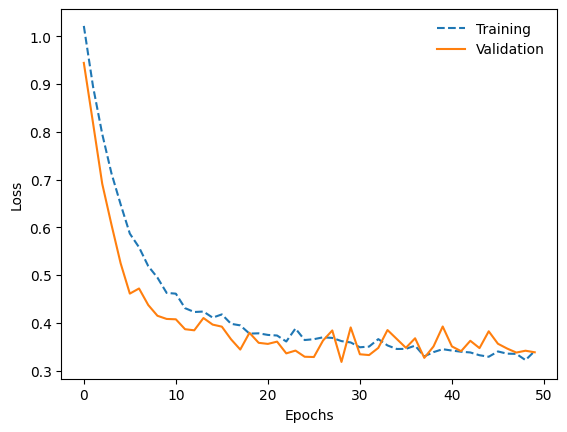

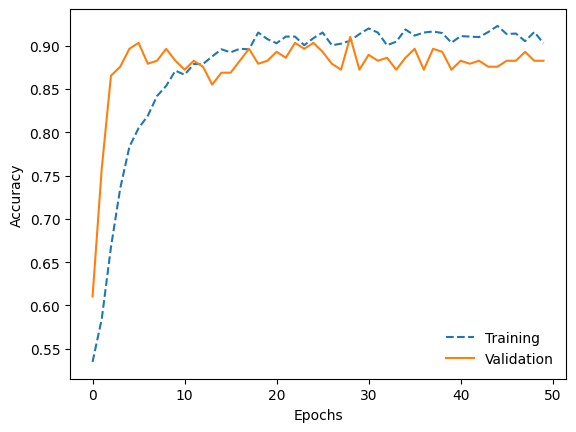

In [30]:
plot_history(history1, '1')

In [31]:
learning_rate = 0.001
l2_lambda = 0.01
dropout = 0.4
optimizer = Adam(learning_rate=learning_rate)

model2 = Sequential([
      Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda),
            input_dim=178),
      Dropout(dropout),
      Dense(1, activation='sigmoid')
      ])

model2.compile(loss='binary_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
model2.summary()

history2 = model2.fit(x=X_train, y=y_train, batch_size=64, epochs=40,
                      validation_data=(X_val, y_val),
                      callbacks=[val_hist, train_hist, test_hist])

Model: "sequential_164"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_402 (Dense)           (None, 64)                11456     
                                                                 
 dropout_238 (Dropout)       (None, 64)                0         
                                                                 
 dense_403 (Dense)           (None, 1)                 65        
                                                                 
Total params: 11521 (45.00 KB)
Trainable params: 11521 (45.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
27/27 [==============================] - 1s 22ms/step - loss: 1.4675 - accuracy: 0.5682 - val_loss: 1.2934 - val_accuracy: 0.6276
Epoch 2/40
27/27 [==============================] - 0s 19ms/step - loss: 1.1297 - accuracy: 0.7626 - val_loss: 1.0186 - val_accuracy: 0.779

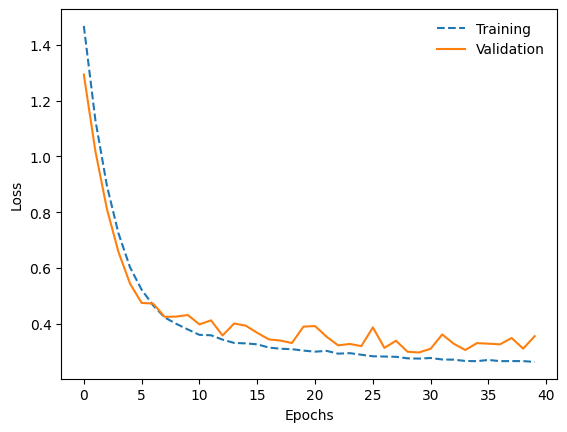

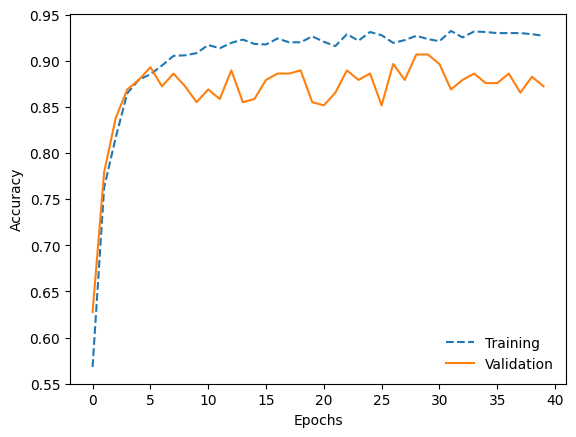

In [32]:
plot_history(history2,'2')

In [33]:
learning_rate = 0.001
l2_lambda = 0.01

optimizer = Adam(learning_rate=learning_rate)

model3 = Sequential([
      Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda),
            input_dim=178),
      Dense(1, activation='sigmoid')
      ])

model3.compile(loss='binary_crossentropy', optimizer=optimizer,
               metrics=['accuracy'])
model3.summary()

history3 = model3.fit(x=X_train, y=y_train, batch_size=64, epochs=40,
                      validation_data=(X_val, y_val))

Model: "sequential_165"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_404 (Dense)           (None, 64)                11456     
                                                                 
 dense_405 (Dense)           (None, 1)                 65        
                                                                 
Total params: 11521 (45.00 KB)
Trainable params: 11521 (45.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
27/27 [==============================] - 1s 10ms/step - loss: 1.4555 - accuracy: 0.5840 - val_loss: 1.2715 - val_accuracy: 0.7000
Epoch 2/40
27/27 [==============================] - 0s 3ms/step - loss: 1.1030 - accuracy: 0.8226 - val_loss: 0.9523 - val_accuracy: 0.8621
Epoch 3/40
27/27 [==============================] - 0s 3ms/step - loss: 0.8462 - accuracy: 0.8819 - val_loss: 0.7463 - val_accuracy

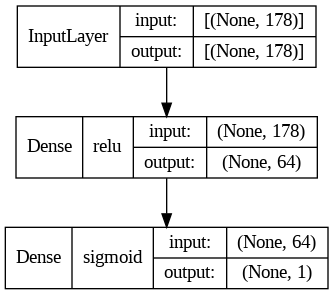

In [34]:
# displaying the network architecture for one of the models (model3) as an example

plot_model(model3, to_file='model_plot.png', show_shapes=True,
           show_layer_names=False, show_layer_activations=True)
Image('model_plot.png')

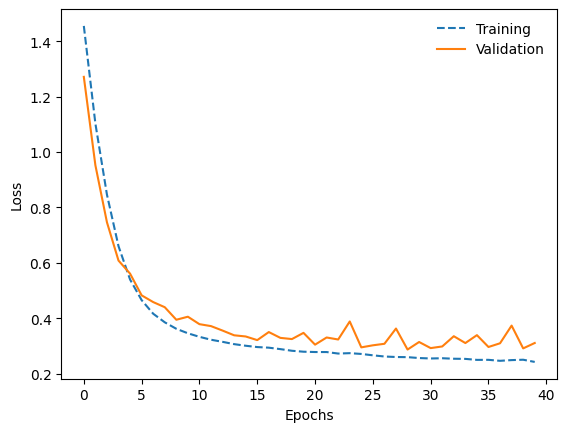

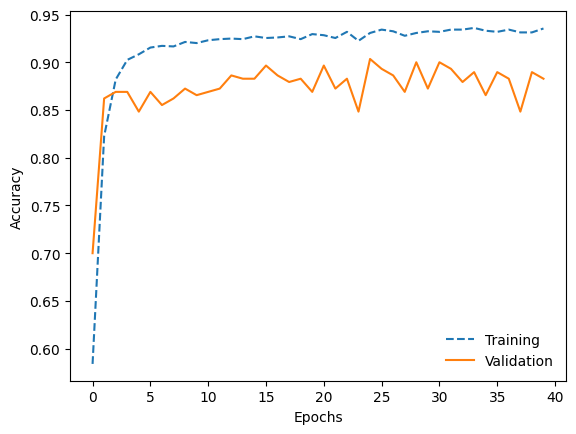

In [35]:
plot_history(history3,'3')

In [36]:
learning_rate = 0.001
l2_lambda = 0.01
dropout = 0.4

optimizer = Adam(learning_rate=learning_rate)

model4 = Sequential([
      Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda),
            input_dim=178),
      Dropout(dropout),
      Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda)),
      Dropout(dropout),
      Dense(1, activation='sigmoid')
      ])

model4.compile(loss='binary_crossentropy', optimizer=optimizer,
               metrics=['accuracy'])
model4.summary()

history4 = model4.fit(x=X_train, y=y_train, batch_size=64, epochs=40,
                      validation_data=(X_val, y_val),
                      callbacks=[val_hist, train_hist, test_hist])

Model: "sequential_166"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_406 (Dense)           (None, 64)                11456     
                                                                 
 dropout_239 (Dropout)       (None, 64)                0         
                                                                 
 dense_407 (Dense)           (None, 32)                2080      
                                                                 
 dropout_240 (Dropout)       (None, 32)                0         
                                                                 
 dense_408 (Dense)           (None, 1)                 33        
                                                                 
Total params: 13569 (53.00 KB)
Trainable params: 13569 (53.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
27/27

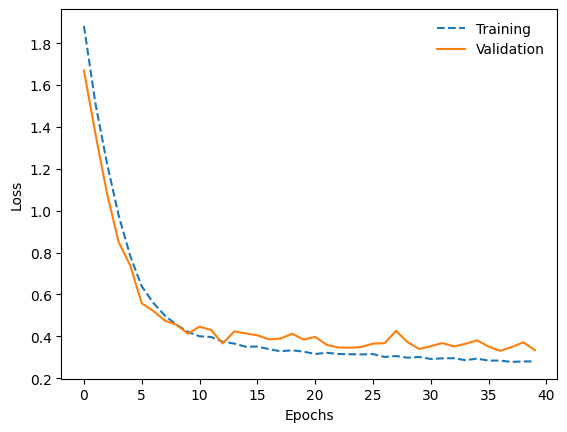

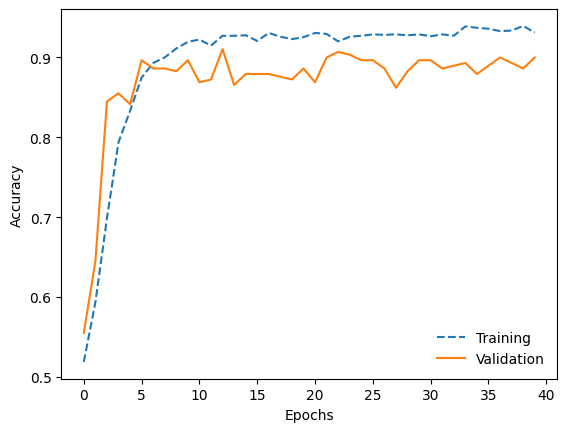

In [37]:
plot_history(history4,'4')

In [38]:
learning_rate = 0.001
l2_lambda = 0.01
dropout = 0.2

optimizer = Adam(learning_rate=learning_rate)

model5 = Sequential([
      Dense(8, activation='relu', kernel_regularizer=l2(l2_lambda),
            input_dim=178),
      Dropout(dropout),
      Dense(1, activation='sigmoid')
      ])

model5.compile(loss='binary_crossentropy', optimizer=optimizer,
               metrics=['accuracy'])
model5.summary()

history5 = model5.fit(x=X_train, y=y_train, batch_size=32, epochs=60,
                      validation_data=(X_val, y_val),
                      callbacks=[val_hist, train_hist, test_hist])

Model: "sequential_167"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_409 (Dense)           (None, 8)                 1432      
                                                                 
 dropout_241 (Dropout)       (None, 8)                 0         
                                                                 
 dense_410 (Dense)           (None, 1)                 9         
                                                                 
Total params: 1441 (5.63 KB)
Trainable params: 1441 (5.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/60
54/54 [==============================] - 2s 17ms/step - loss: 0.8111 - accuracy: 0.5259 - val_loss: 0.7387 - val_accuracy: 0.7069
Epoch 2/60
54/54 [==============================] - 1s 12ms/step - loss: 0.7218 - accuracy: 0.6845 - val_loss: 0.6455 - val_accuracy: 0.8069
Ep

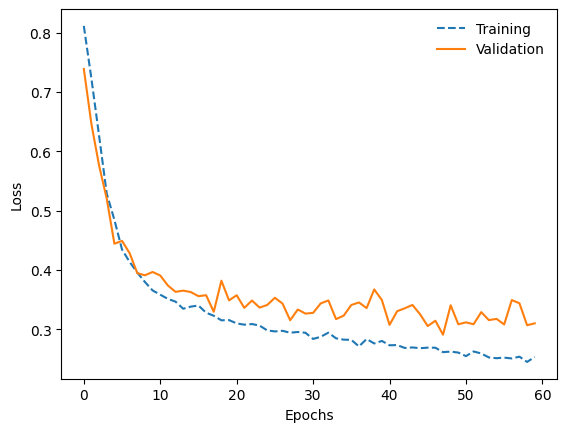

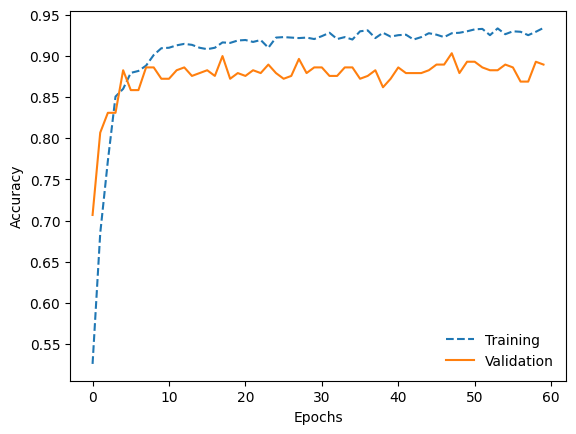

In [39]:
plot_history(history5,'5')

##Evaluation



In [43]:
def plot_confusion_matrix(cm, classes, method,
                          normalize=False,
                          title='Confusion matrix ',
                          cmap=plt.cm.Blues, mod_num=""):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title + method + mod_num)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.savefig(f"{file_dir}//HIV-CP Plots/Confusion matrix "+
                method + mod_num + ".png")
    plt.show()

In [41]:
def evaluate(x_test, Y_test, model, mod_num):

    ##Evaluate loss and metrics
    loss, accuracy = model.evaluate(x_test, Y_test, verbose=0)
    print('Test Loss:', loss)
    print('Test Accuracy:', accuracy)
    # Predict the values from the test dataset
    Y_pred = model.predict(x_test)

    Y_cls = [0]
    for i in range(len(Y_pred)):
      if Y_pred[i] <= 0.5:
        Y_cls = np.append(Y_cls,0)
      else:
        Y_cls = np.append(Y_cls,1)
    Y_cls = Y_cls[1:]

    cr = classification_report(Y_test, Y_cls, output_dict=True)
    print('Classification Report:\n', classification_report(Y_test,Y_cls))

    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_test, Y_cls)

    tn=confusion_mtx[0][0]
    fp=confusion_mtx[0][1]
    fn=confusion_mtx[1][0]
    tp=confusion_mtx[1][1]

    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    f1 = cr['weighted avg']['f1-score']

    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

    print('AUC:', auc(fpr,tpr))
    print('Sensitivity:', sensitivity)
    print('Specificity:', specificity)
    print('Average of performance metrics:',
          (accuracy+sensitivity+specificity+auc(fpr,tpr)+f1)/5)

    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, classes = (0,1), method="MLP ",
                          mod_num=mod_num)

    disp = ConfusionMatrixDisplay.from_predictions(Y_test,Y_cls,
                                                   display_labels=(0,1),
                                                   cmap=plt.cm.Blues,
                                                   normalize='true')

    disp.ax_.set_title("Normalized confusion matrix MLP "+mod_num)

    plt.savefig(f"{file_dir}//HIV-CP Plots/Normalized confusion matrix MLP "+
                mod_num + ".png")
    plt.show()

    #creating ROC curve
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Test Loss: 0.2947002351284027
Test Accuracy: 0.9098639488220215
19/19 [==============================] - 0s 12ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       488
           1       0.67      0.91      0.77       100

    accuracy                           0.91       588
   macro avg       0.83      0.91      0.86       588
weighted avg       0.93      0.91      0.91       588

AUC: 0.968811475409836
Sensitivity: 0.91
Specificity: 0.9098360655737705
Average of performance metrics: 0.9226822826381991


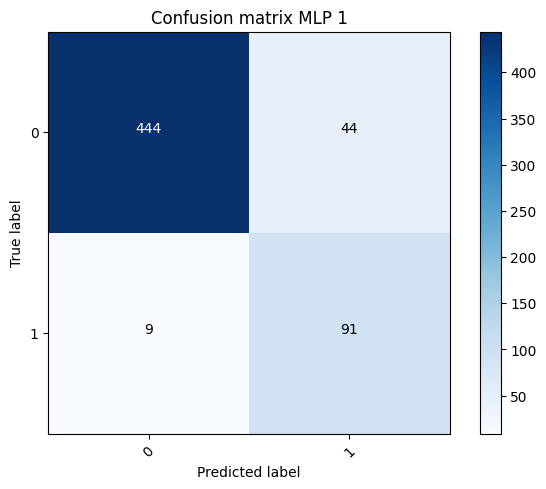

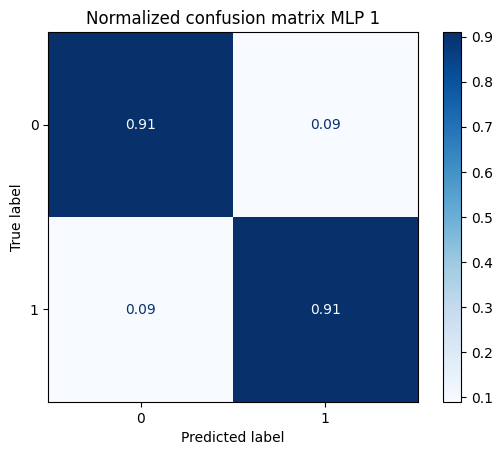

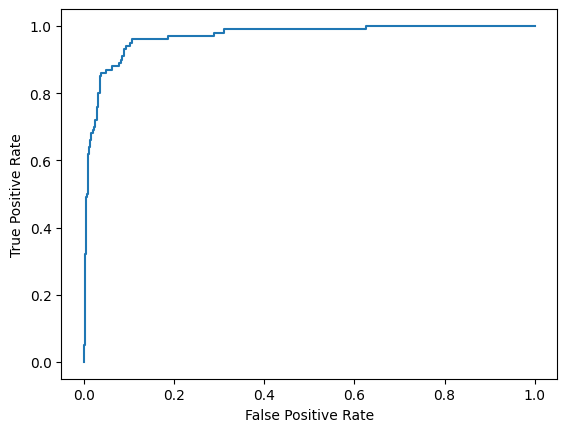

In [44]:
evaluate(X_test, y_test, model1, '1')

Test Loss: 0.31033897399902344
Test Accuracy: 0.8996598720550537
19/19 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94       488
           1       0.64      0.96      0.76       100

    accuracy                           0.90       588
   macro avg       0.81      0.92      0.85       588
weighted avg       0.93      0.90      0.91       588

AUC: 0.9663319672131148
Sensitivity: 0.96
Specificity: 0.8872950819672131
Average of performance metrics: 0.9240749139810547


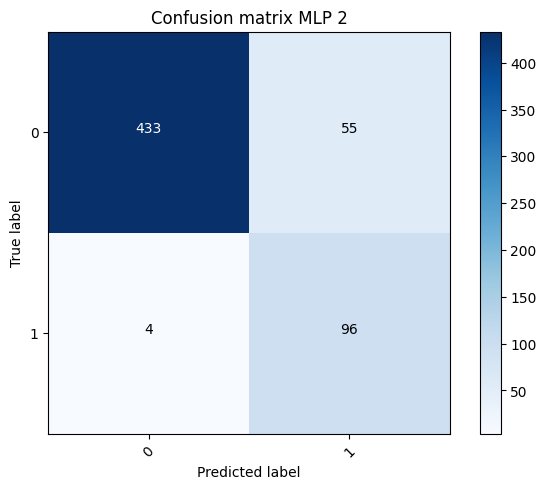

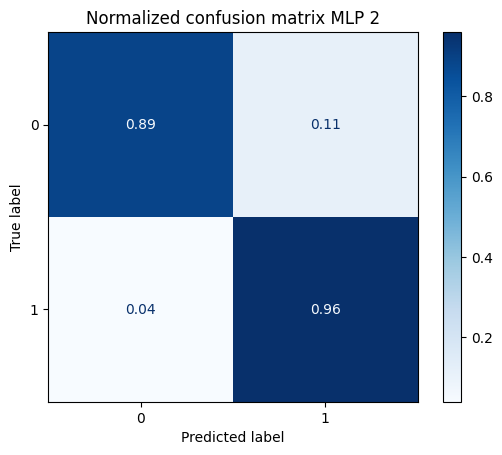

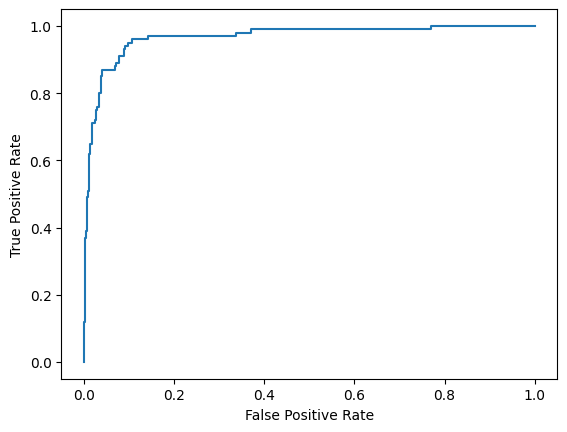

In [45]:
evaluate(X_test, y_test, model2, '2')

Test Loss: 0.2702876031398773
Test Accuracy: 0.9200680255889893
19/19 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       488
           1       0.70      0.93      0.80       100

    accuracy                           0.92       588
   macro avg       0.84      0.92      0.87       588
weighted avg       0.94      0.92      0.92       588

AUC: 0.9655122950819671
Sensitivity: 0.93
Specificity: 0.9180327868852459
Average of performance metrics: 0.9315885911651829


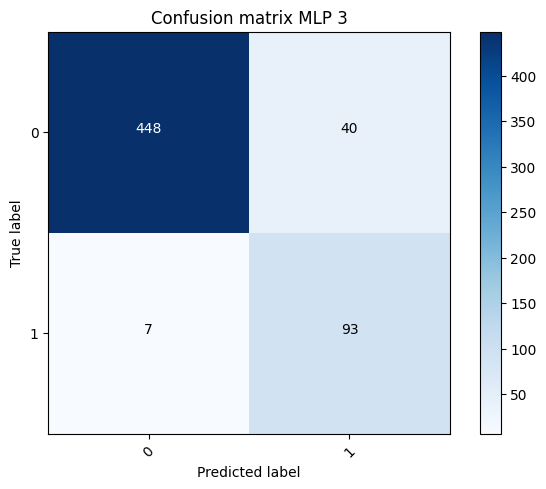

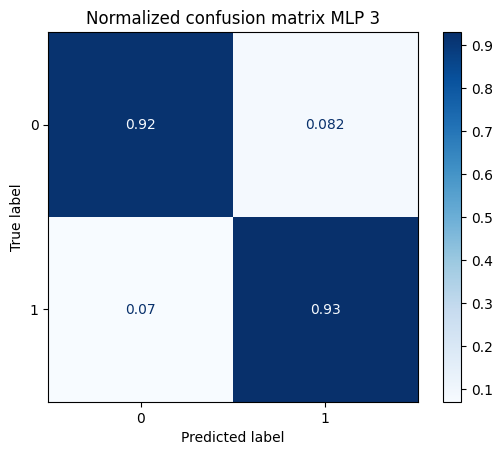

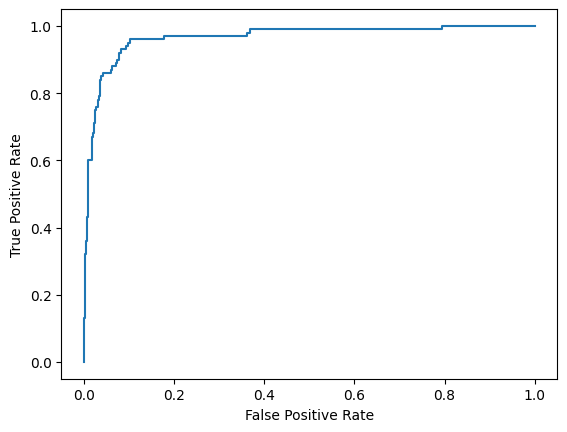

In [46]:
evaluate(X_test, y_test, model3, '3')

Test Loss: 0.2898229658603668
Test Accuracy: 0.9166666865348816
19/19 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       488
           1       0.70      0.90      0.79       100

    accuracy                           0.92       588
   macro avg       0.84      0.91      0.87       588
weighted avg       0.93      0.92      0.92       588

AUC: 0.9661680327868852
Sensitivity: 0.9
Specificity: 0.9200819672131147
Average of performance metrics: 0.9247167917613247


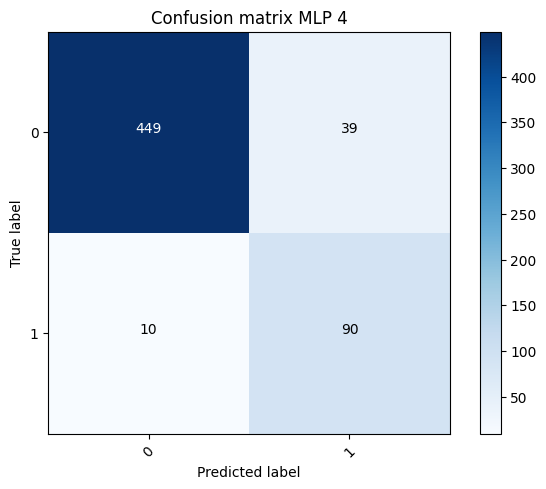

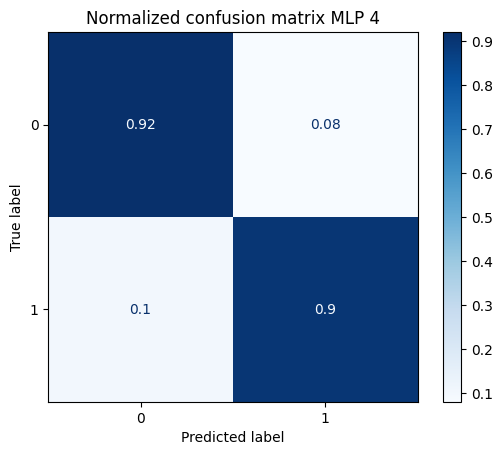

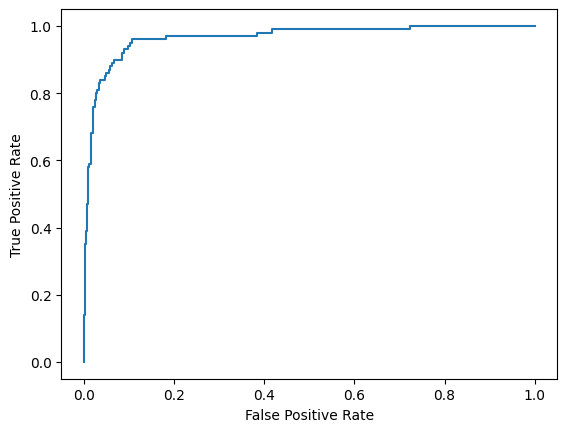

In [47]:
evaluate(X_test, y_test, model4, '4')

Test Loss: 0.26675570011138916
Test Accuracy: 0.9166666865348816
19/19 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.95       488
           1       0.69      0.93      0.79       100

    accuracy                           0.92       588
   macro avg       0.84      0.92      0.87       588
weighted avg       0.93      0.92      0.92       588

AUC: 0.9670286885245901
Sensitivity: 0.93
Specificity: 0.9139344262295082
Average of performance metrics: 0.9297904743932037


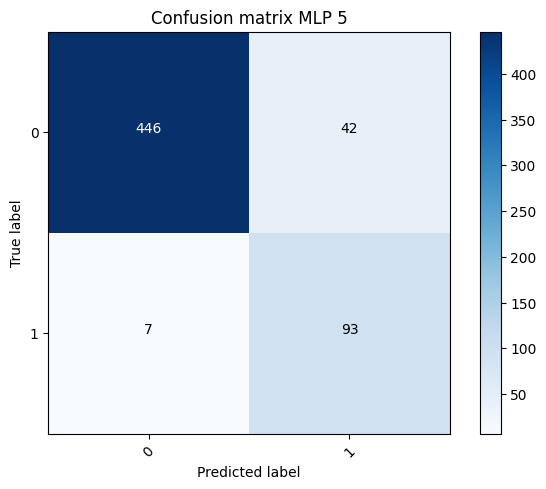

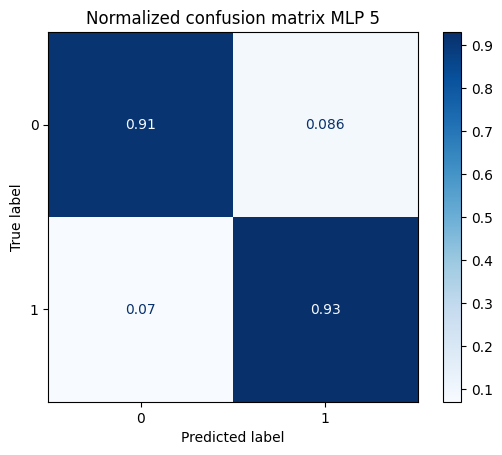

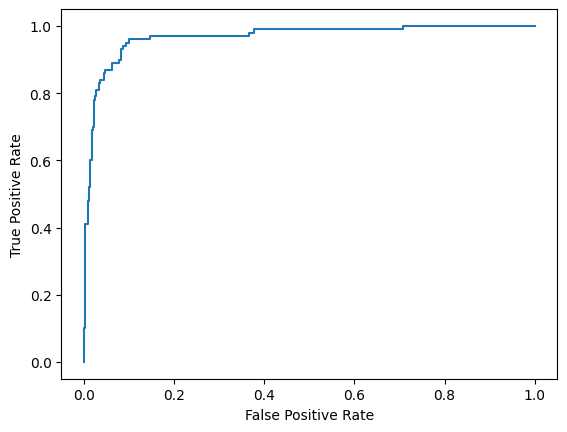

In [48]:
evaluate(X_test, y_test, model5, '5')

# Method 2: *k*-NN

In [49]:
X_train_am = X_train
y_train_am = y_train

X_test_am = np.concatenate((X_test,X_val), axis=0)
y_test_am = np.concatenate((y_test,y_val), axis=0)

Accuracy: 0.83
B. Accuracy: 0.84
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.83      0.89       728
           1       0.51      0.85      0.64       150

    accuracy                           0.83       878
   macro avg       0.74      0.84      0.76       878
weighted avg       0.89      0.83      0.85       878

AUC: 0.9021336996336995
Sensitivity: 0.8533333333333334
Specificity: 0.8296703296703297
F1-score: 0.8485457022917298
Average of performance metrics: 0.8534792097967525


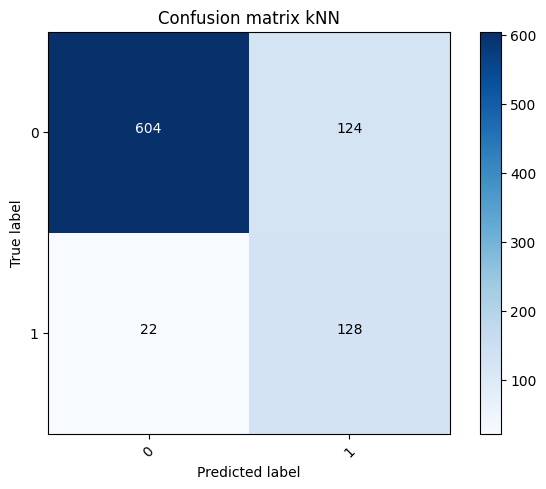

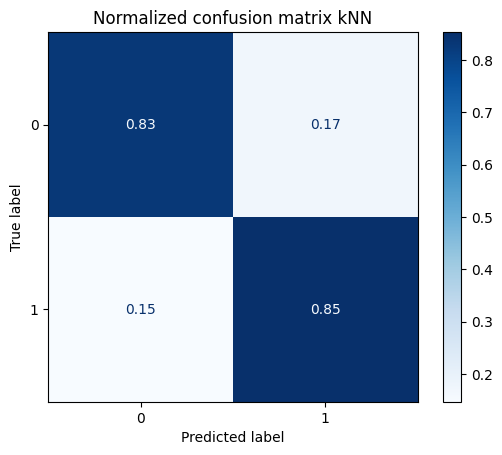

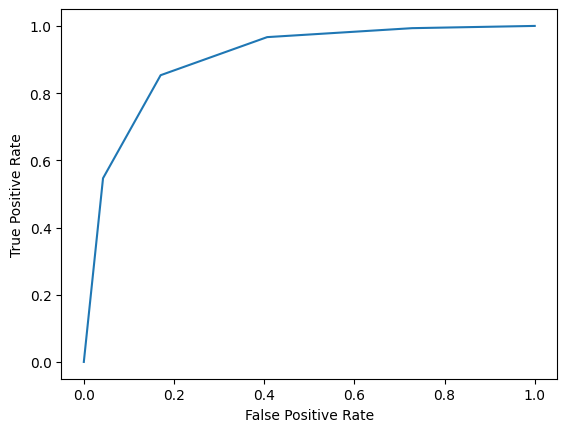

In [50]:
kn = KNeighborsClassifier(n_neighbors=4)

kn.fit(X_train_am, y_train_am)

y_prob_kNN = kn.predict_proba(X_test_am)
y_pred_kNN = kn.predict(X_test_am)

print('Accuracy: %.2f' % accuracy_score(y_test_am, y_pred_kNN))
print('B. Accuracy: %.2f' % balanced_accuracy_score(y_test_am, y_pred_kNN))
print('Classification Report:\n', classification_report(y_test_am, y_pred_kNN))

cr = classification_report(y_test_am, y_pred_kNN, output_dict=True)

confusion_mtx = confusion_matrix(y_test_am, y_pred_kNN)

tn = confusion_mtx[0][0]
fp = confusion_mtx[0][1]
fn = confusion_mtx[1][0]
tp = confusion_mtx[1][1]

accuracy = accuracy_score(y_test_am, y_pred_kNN)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
f1 = cr['weighted avg']['f1-score']

fpr2, tpr2, thresholds2 = roc_curve(y_test_am, y_prob_kNN[:,1])
auc2 = auc(fpr2,tpr2)

print('AUC:', auc2)
print('Sensitivity:', tp/(tp+fn))
print('Specificity:', tn/(tn+fp))
print('F1-score:', f1)
print('Average of performance metrics:',
      (accuracy+sensitivity+specificity+auc2+f1)/5)

plot_confusion_matrix(confusion_mtx, classes = (0,1), method="kNN")

disp = ConfusionMatrixDisplay.from_estimator(kn, X_test_am, y_test_am,
                                             display_labels=(0,1),
                                             cmap=plt.cm.Blues,
                                             normalize='true')
disp.ax_.set_title("Normalized confusion matrix kNN")

plt.savefig(f"{file_dir}//HIV-CP Plots/Normalized confusion matrix kNN.png")
plt.show()

plt.plot(fpr2,tpr2)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Method 3: Logistic Regression

Accuracy: 0.91
B. Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94       728
           1       0.66      0.92      0.77       150

    accuracy                           0.91       878
   macro avg       0.82      0.91      0.85       878
weighted avg       0.93      0.91      0.91       878

AUC: 0.9634615384615384
Sensitivity: 0.92
Specificity: 0.9024725274725275
F1-score: 0.9112387812508975
Average of performance metrics: 0.9205279635144414


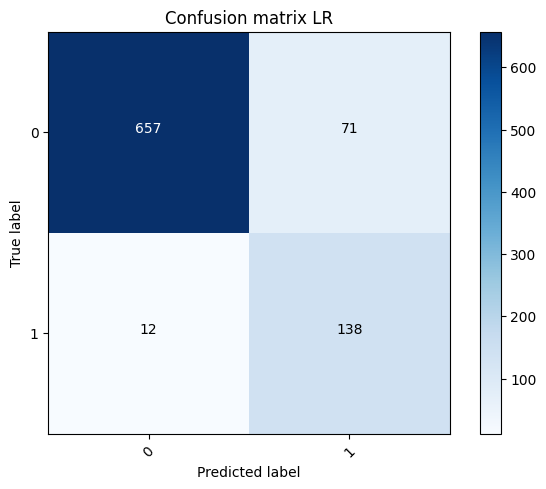

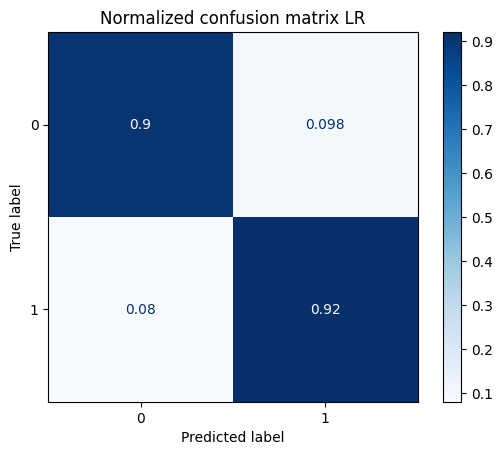

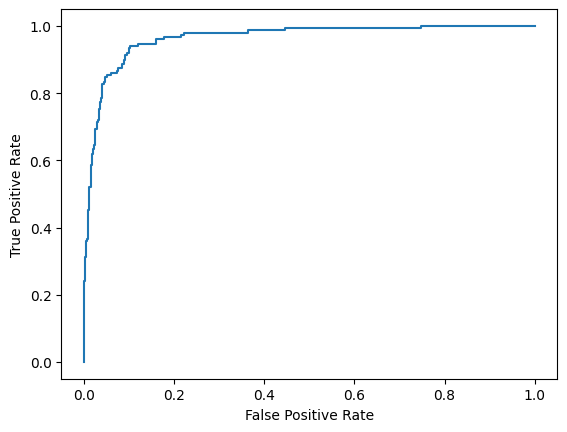

In [51]:
lr = LogisticRegression(solver='lbfgs',
                        multi_class='ovr',
                        penalty='l2',
                        n_jobs=-1,
                        random_state=42)

lr.fit(X_train_am, y_train_am)

y_prob_lr = lr.predict_proba(X_test_am)
y_pred_lr = lr.predict(X_test_am)

print('Accuracy: %.2f' % accuracy_score(y_test_am, y_pred_lr))
print('B. Accuracy: %.2f' % balanced_accuracy_score(y_test_am, y_pred_lr))
print('Classification Report:\n', classification_report(y_test_am, y_pred_lr))

cr = classification_report(y_test_am, y_pred_lr, output_dict=True)

confusion_mtx = confusion_matrix(y_test_am, y_pred_lr)

tn = confusion_mtx[0][0]
fp = confusion_mtx[0][1]
fn = confusion_mtx[1][0]
tp = confusion_mtx[1][1]

accuracy = accuracy_score(y_test_am, y_pred_lr)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
f1 = cr['weighted avg']['f1-score']

fpr3, tpr3, thresholds3 = roc_curve(y_test_am, y_prob_lr[:,1])
auc3 = auc(fpr3,tpr3)

print('AUC:', auc3)
print('Sensitivity:', tp/(tp+fn))
print('Specificity:', tn/(tn+fp))
print('F1-score:', f1)
print('Average of performance metrics:',
      (accuracy+sensitivity+specificity+auc3+f1)/5)

plot_confusion_matrix(confusion_mtx, classes = (0,1), method="LR")

disp = ConfusionMatrixDisplay.from_estimator(lr, X_test_am, y_test_am,
        display_labels=(0,1), cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("Normalized confusion matrix LR")

plt.savefig(f"{file_dir}//HIV-CP Plots/Normalized confusion matrix LR.png")
plt.show()

plt.plot(fpr3,tpr3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [52]:
def compare_roccurves():
  plt.figure()
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')

  y_pred_MLP = model3.predict(X_test)
  fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_MLP)

  plt.plot(fpr1,tpr1)
  plt.plot(fpr2,tpr2)
  plt.plot(fpr3,tpr3)

  plt.legend(['MLP','kNN','LR'], frameon=False)
  plt.savefig(f"{file_dir}//HIV-CP Plots/ROC.png")

  plt.show()

19/19 [==============================] - 0s 1ms/step


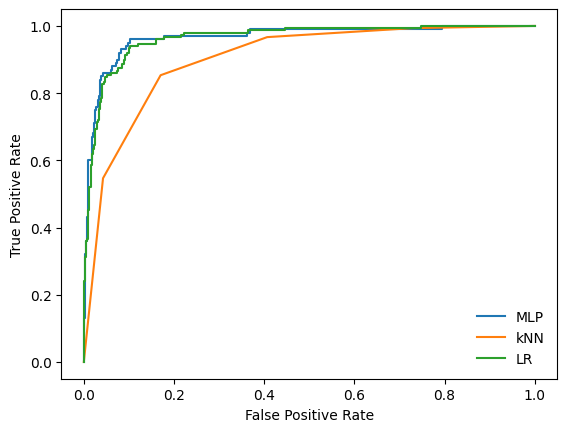

In [53]:
compare_roccurves()